# This Jupyter notebook collects user comments on LinkedIn posts in which the desired company is tagged, and uses natural language processing to provide a brief sentiment analysis for those comments.

In [30]:
import pandas as pd
import numpy as np

from getpass import getpass
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time

import matplotlib.pyplot as plt
import seaborn as sns

## Scraping Data from Linkedin

#### Autentication

In [36]:
username = input("USERNAME: ")
password = getpass("PASSWORD: ")

#### Company Search

In [37]:
company = input("COMPANY: ")

#### Login

In [38]:
driver = webdriver.Chrome()
driver.get('https://www.linkedin.com')
username_field = driver.find_element(By.ID, 'session_key')
password_field = driver.find_element(By.ID, 'session_password')
username_field.send_keys(username)
password_field.send_keys(password)
password_field.send_keys(Keys.ENTER)

In [40]:
# Go to Linkedin company page
search_bar = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="global-nav-typeahead"]/input')))
search_bar.send_keys(company)
search_bar.send_keys(Keys.ENTER)

# Go to post section
time.sleep(5)
posts_section = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="search-reusables__filters-bar"]/ul/li[1]/button')))
posts_section.send_keys(Keys.ENTER)


#### Scraper

In [41]:
# Scroll function
def scroll_to_bottom():
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
        
# Click on "Carica altri commenti" buttons functions
def click_load_more_comments():
    load_more_comments_buttons = driver.find_elements(By.XPATH, "//span[@class='artdeco-button__text' and text()='Carica altri commenti']")
    for button in load_more_comments_buttons:
        driver.execute_script("arguments[0].click();", button)
        time.sleep(2)

# Take comments function
def get_comments():
    new_comments = driver.find_elements(By.XPATH, "//span[@dir='ltr']")
    updated_comments = []
    for comment in new_comments:
        updated_comments.append(comment.text)
    return updated_comments

all_comments = []

In [42]:
start_time = time.time() # Scroll Start time
total_time = 400 # Total scoll time in sec.

while True:
    scroll_to_bottom()
    elapsed_time = time.time() - start_time
    if elapsed_time >= total_time:
        break
click_load_more_comments()
time.sleep(60)
get_comments()

all_comments = get_comments()

#### DataFrame

In [43]:
comments_raw=pd.DataFrame(all_comments)
comments=comments_raw.copy()
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3518 non-null   object
dtypes: object(1)
memory usage: 27.6+ KB


In [44]:
comments.sample(10)

,0
2504,Ambra Giannone\nVisualizza il profilo di Ambra...
2912,Florian Reins\nVisualizza il profilo di Floria...
1663,Rasaq Raji\nVisualizza il profilo di Rasaq Raji
1333,Davide Annovazzi\nVisualizza il profilo di Dav...
445,Giuseppe Marotta\nVisualizza il profilo di Giu...
2760,Tra le aziende Outlier del network Endeavor ne...
1327,They have not seen the matrix then ;)
956,Grazie Manuela :)
665,Michael Lagarde\nVisualizza il profilo di Mich...
2443,"Booking.com: The largest selection of hotels, ..."


## Dtaset Cleaning

In [60]:
comments = comments.rename(columns={"0":"Comments"})

comments["Comments"] = comments["Comments"].str.lower()

comments=comments.dropna()

filtro = comments["Comments"].str.contains("visualizza il profilo di")
comments = comments[~filtro].reset_index(drop=True)

print(comments.sample(10))

                                               Comments  \
251                    riccardo ferrara in classifica!!   
365   il pranzo è il dramma giornaliero: capire dove...   
463   anno di crescita, chissà cosa ci riserverà il ...   
813           jobs.bendingspoons.com • 1 min di lettura   
2096  milan-innovation-ecosystem-new-era.fdiintellig...   
2013  thanks gp bullhound 😀 ! quite a surprise to se...   
435   bel colpo! anche se evernote forse non è più s...   
1673                                             joinrs   
1733                                      forbes italia   
756                                       andrea zurini   

                                           Comments_eng  
251                 Riccardo Ferrara in the standings!!  
365   lunch is the daily drama: figuring out where/w...  
463   year of growth, who knows what 2023 will have ...  
813                 jobs.bendingspoons.com • 1 min read  
2096  milan-innovation-ecosystem-new-era.fdiintellig...  
20

## English Translation

In [52]:
from deep_translator import GoogleTranslator
import langdetect

In [57]:
# Language detect function
def detect_language(text):
    try:
        lang = langdetect.detect(text)
    except:
        lang = 'unknown'
    return lang

# Translation function
def translate_to_english(text):
    translator = GoogleTranslator(source='auto', target='en')
    text = translator.translate(text)
    return text

comments['Comments_eng'] = comments.apply(lambda x: translate_to_english(x['Comments']) if detect_language(x['Comments']) != 'en' else x['Comments'], axis=1)

In [64]:
comments.sample(10)

,Comments,Comments_eng
2052,"so, ghosting candidates now has the additional...","so, ghosting candidates now has the additional..."
456,gabriella rocco,Gabriella Rocco
1556,to read our newsletter : https://7892638.hs-si...,to read our newsletter : https://7892638.hs-si...
810,luca ferrari,Luca Ferrari
2272,congratulations!!,congratulations!!
144,grazie nicolò!,thanks nicole!
200,startupitalia.eu • 2 min di lettura,startupitalia.eu • 2 min of reading
1304,super!,super!
2221,"true, let go of control and embrace uncertaint...","true, let go of control and embrace uncertaint..."
1522,"🇮🇹 italy is on fire (no, not for football)\nth...","🇮🇹 italy is on fire (no, not for football)\nth..."


## Removing records containing only personal names using Natural Language Processing

In [65]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [66]:
def remove_name_only_rows(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON" and len(text.split()) <= 2:
            return True
    return False

comments_only_names = comments[comments['Comments_eng'].apply(remove_name_only_rows)]

In [69]:
comments_only_names.sample(5)

,Comments,Comments_eng
239,riccardo porta,richard door
574,alessia liotta,Alessia Liotta
1543,vipin kumar,vipin kumar
127,daniel eid,Daniel Eid
1516,federico scolari,Federico Scolari


In [70]:
comments = comments[~comments['Comments_eng'].isin(comments_only_names['Comments_eng'])]

In [71]:
#comments.to_csv("BendingSpoons.csv")

## Brief Sentiment Ananlysis using a pretrained model based on BERT from Huggingface


In [72]:
comments = pd.read_csv("C:/Users/Lavoro/Desktop/Linkedin Sentiment/BendingSpoons.csv")
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2156 non-null   int64 
 1   Comments      2156 non-null   object
 2   Comments_eng  2156 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.7+ KB
None


In [75]:
comments.sample(5)

,Unnamed: 0,Comments,Comments_eng
500,534,pensare che qualcosa sia impossibile significa...,thinking that something is impossible means mi...
225,242,grazie per il tuo contributo andrea,Thanks for your input Andrew
2063,2214,enjoy the startup live!,enjoy the startup live!
464,493,elia milani pietro benedetto molini,elia milani pietro benedetto molini
942,1023,mariangela caineri zenati,mariangela caineri zenati


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length = 511)

In [ ]:
# Test
sentiment("some time i like play football")


In [78]:
# Function to apply the sentiment pipeline
def get_sentiment(comment):
    result = sentiment(comment)[0]
    return result['label']

# apply the sentiment pipeline to each comment in the 'Comments_eng' column
comments['Sentiment'] = comments['Comments_eng'].apply(get_sentiment)

In [79]:
comments.sample(10)

,Unnamed: 0,Comments,Comments_eng,Sentiment
2068,2220,"fixed scope is crippling for pm, team and most...","fixed scope is crippling for pm, team and most...",negative
1551,1686,thanks! sunday ezema 🔥,thanks! sunday ezema 🔥,positive
415,443,questa è una cosa pazzesca e importantissima ! 😍🚀,This is crazy and super important! 😍🚀,positive
1184,1284,love this success story!,love this success story!,positive
239,256,go storeis 🙌🏻,go storeis 🙌🏻,positive
1153,1251,congrats emi ! being a person with great taste...,congrats emi ! being a person with great taste...,positive
288,308,"fico eh, ma gli anni d’oro di evernote non son...","cool eh, but haven't the golden years of evern...",positive
749,815,"olanrewaju olokunola, aca please check this out.","olanrewaju olokunola, aca please check this out.",neutral
99,106,always interesting!,always interesting!,positive
2099,2252,thanks komal pal,thanks komal pal,positive


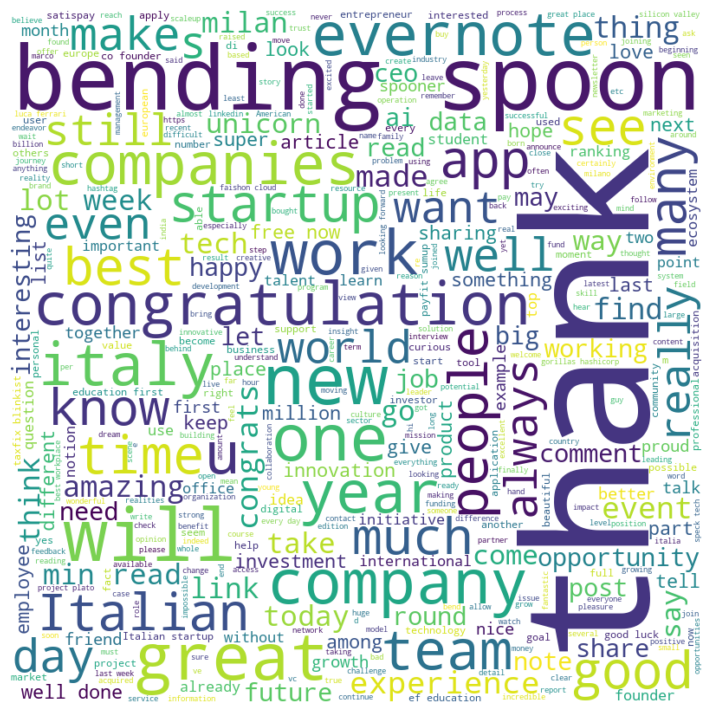

In [80]:
from wordcloud import WordCloud

text = " ".join(comment for comment in comments["Comments_eng"])
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=400, max_font_size=200)
wordcloud.generate(text)

plt.figure(figsize=(9, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


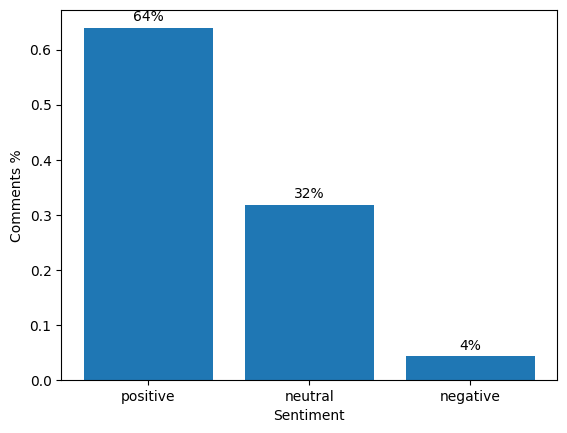

In [81]:

sentiment_counts = comments['Sentiment'].value_counts(normalize=True)

fig, ax = plt.subplots()

bars = ax.bar(sentiment_counts.index, sentiment_counts.values)

ax.set_xlabel("Sentiment")
ax.set_ylabel("Comments %")

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0%}', xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.show()
